KWIKVAL - Rui Cruzeiro - Dezembro 2022

O objectivo deste documento é a criação de uma ferramenta simples de avaliação de apartamentos (Kwikval) com recurso a Machine Learning. Os passos dados pela ferramenta são os seguintes:
1. INPUTS: Pedir ao utilizador um distrito, um concelho, coordenadas geográficas e as áreas do imóvel;
2. API: Pesquisar os anúncios do Idealista que mais se assemelham ao fornecido pelo utilizador. Para tal, foi criada uma conta no RapidAPI que permite 500 pesquisas gratuitas por mês na API do Idealista;
3. MÉTODO TRADICIONAL (COMPARATIVO DE MERCADO): Fazer homogeneização de áreas e dedução da margem de negociação;
4. MACHINE LEARNING: Aplicação de Regressão Linear com o Scikit-Learn (o que corresponde à aplicação do Método Comparativo de Mercado (método tradicional de avaliação imobiliária).

In [1]:
import numpy as np
import pandas as pd
import requests
from math import radians, cos, sin, asin, sqrt
from concelhos import dados_concelhos
from idealista_api import api_key
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

## INPUTS

O utilizador introduz as informações seguintes, devendo as áreas ser extraídas da Caderneta Predial Urbana do apartamento. Distrito, concelho, tipologia e Área Bruta Privativa são usados para construir o request a fazer à API do Idealista.

In [2]:
# Exemplo de trabalho

user_distrito = 'Coimbra'
user_concelho = 'Coimbra'
user_tipologia = 2       # T1, T2, T3, etc.
user_area = 83           # Área Bruta Privativa
user_dep = 39            # Área Bruta Dependente
user_wcs = 1             # Número de casas de banho
user_andar = 0           # Piso (Caves, sub-caves e r/c são 0)
user_tem_elev = 'Lift'   # Lift ou NoLift
user_tem_estac = 'Park'  # Park ou NoPark

O utilizador fornece também as coordenadas de localização do imóvel. Estas serão usadas para seleccionar os imóveis mais próximos entre todos aqueles devolvidos pelo request à API.

In [3]:
user_lat = 40.201607
user_lon = -8.398265
user_coord_str = str(user_lat) + ',' + str(user_lon)

As coordenadas fornecidas pelo utilizador não podem ultrapassar os limites geográficos de Portugal.

In [4]:
# Pontos geográficos extremos de Portugal
max_lat_N = 42.153978
max_lat_S = 32.632960
max_lon_W = -31.274995
max_lon_E = -6.189363

## API

Para obter uma lista de imóveis à venda numa zona, é necessário fazer um GET request à API introduzindo o ID e o nome da zona. O ID da zona corresponde à concatenação apresentada no campo seguinte, em que o dicionário `dados_concelhos`, construído manualmente, faz corresponder um número ao concelho inserido pelo utilizador. Na maior parte dos concelhos, esse número corresponde ao código da Autoridade Tributária para o concelho. O nome da zona é obtido na própria API partindo do ID.

Obtenção do ID da zona:

In [5]:
zona_id = '0-EU-PT-' + dados_concelhos[user_distrito][user_concelho]
zona_id

'0-EU-PT-06-03'

Obtenção do nome da zona:

In [6]:
# Obtém json da API com informação sobre IDs e nomes de zonas similares ao do concelho fornecido pelo utilizador

url = "https://idealista2.p.rapidapi.com/auto-complete"
querystring = {"prefix":user_concelho, "country":"pt"}

headers = {
    "X-RapidAPI-Key": api_key,
    "X-RapidAPI-Host": "idealista2.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)
zonas = response.json()

# Compara as zonas obtidas acima com a zona pretendida através do ID da zona e obtém o nome

for zona in zonas['locations']:
    try:
        if zona['locationId'] == zona_id:
            zona_nome = zona['name']
    except Exception:
        pass
    
zona_nome

'Coimbra, Coimbra'

Com o ID e o nome, é possível obter a lista das propriedades no concelho escolhido (usando também as coordenadas). Esta informação é actualizada diariamente pelo Idealista. A API só permite um número máximo de 40 resultados por request, portanto são feitos 3 requests às 3 primeiras páginas de resultados correspondentes.
É feito um pedido de anúncios activos de imóveis residenciais com uma variação de área de 10% relativamente ao imóvel em avaliação.

In [7]:
# Recolhe a informação nas 3 primeiras páginas de resultados do Idealista
# (O Idealista não lança mais do que 40 resultados por página, mesmo que maxItens seja superior)

url = "https://idealista2.p.rapidapi.com/properties/list"

resultados_pesq = []

for i in range(1,4): # 3 requests
    
    querystring = {
        "locationId": zona_id,
        "locationName": zona_nome,
        "operation": "sale",
        "numPage": str(i), # 3 primeiras páginas
        "propertyType": "homes",
        "center": user_coord_str,
        "distance": 10,
        "maxSize": int(user_area * 1.1),
        "minSize": int(user_area * 0.9),
        "state": "active",
        "maxItems": 50,
        "sort": "asc", # ascendente em preço
        "locale": "pt",
        "country": "pt"
    }

    headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "idealista2.p.rapidapi.com"
    }

    response = requests.request("GET", url, headers=headers, params=querystring)
    resultados_pesq.append(response.json()['elementList'])

# Cria uma lista "flattened" com os 120 resultados    
resultados_lista = [item for sublist in resultados_pesq for item in sublist]

A API só permite filtrar por `"homes"`, o que inclui todo o tipo de imóveis residenciais, não só apartamentos. Portanto, é necessário filtrar a lista obtida acima por `"flat"`. Na filtragem, também se descartaram os imóveis com tipologias diferentes à do imóvel em apreço.

Nota: Os resultados filtrados encontrados a seguir serão usados na secção de Machine Learning.

In [8]:
# Filtra apenas os apartamentos

resultados_filtrados = []

for resultado in resultados_lista:
    if resultado['propertyType'] == 'flat' and resultado['rooms'] == user_tipologia:
        resultados_filtrados.append(resultado)

## MÉTODO TRADICIONAL (COMPARATIVO DE MERCADO)

De todos os resultados, são seleccionados os que têm coordenadas mais próximas à fornecida pelo utilizador. O número máximo de comparáveis a usar, `n`, é escolhido de seguida.

In [9]:
n_comparaveis = 20

Para cálculo da distância entre o imóvel em avaliação e os da lista, foi usada a fórmula de haversine. Esta foi definida na função seguinte.

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Distância entre dois pontos de uma esfera a partir das suas latitudes e longitudes
    """
    
    # Converte graus decimais para radianos
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Fórmula de haversine 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Raio da Terra em quilómetros
    return c * r

In [11]:
# Calcula as distâncias haversine e devolve a lista dos 10 imóveis mais próximos (comparáveis para o Método Comparativo)

distancias_lista = []

for resultado in resultados_filtrados:
    distancias_lista.append(haversine(user_lat, user_lon, float(resultado['latitude']), float(resultado['longitude'])))
    
distancias_ind = [distancias_lista.index(dist) for dist in sorted(distancias_lista)[:n_comparaveis]]

comparaveis = [resultados_filtrados[ind] for ind in distancias_ind]

Estes são os `n` comparáveis mais próximos geograficamente do apartamento que se pretende avaliar:

In [12]:
for comparavel in comparaveis:
    print('https://www.idealista.pt/imovel/' + comparavel['propertyCode'])

https://www.idealista.pt/imovel/32256241
https://www.idealista.pt/imovel/31585637
https://www.idealista.pt/imovel/32237085
https://www.idealista.pt/imovel/32257759
https://www.idealista.pt/imovel/32256240
https://www.idealista.pt/imovel/32276019
https://www.idealista.pt/imovel/32181843
https://www.idealista.pt/imovel/32181843
https://www.idealista.pt/imovel/32181843
https://www.idealista.pt/imovel/32320515
https://www.idealista.pt/imovel/32270033
https://www.idealista.pt/imovel/32299754
https://www.idealista.pt/imovel/32320612
https://www.idealista.pt/imovel/32320545
https://www.idealista.pt/imovel/32299755
https://www.idealista.pt/imovel/32270032
https://www.idealista.pt/imovel/31797881
https://www.idealista.pt/imovel/32299781
https://www.idealista.pt/imovel/32270040
https://www.idealista.pt/imovel/32320623


Visto que o valor do apartamento não varia linearmente com a área, é necessário fazer homogeneização de áreas. Esta foi feita com base na Fórmula de Ajustamento de Pulsares do Prof. Ruy Figueiredo, que ajusta a área de imóveis residenciais calculando um factor de homogeneização pela fórmula seguinte:

$f_{homogeneização} = \Biggl( \dfrac{A_{comparável}}{A_{imóvel \thinspace em \thinspace avaliação}}\ \Biggr) ^{1/4} $

Na homogeneização, é também deduzida uma percentagem de 5% ao valor anunciado dos comparáveis, correspondente à habitual margem de negociação, assim como uma percentagem de 10% se o imóvel anunciado tiver estacionamento e este estiver incluído no valor.

In [13]:
### Homogeneização ###

# Valores unitários dos comparáveis
val_unit_comparaveis = [comparavel['price']/comparavel['size'] for comparavel in comparaveis]

# Coeficientes de homogeneização de área
f_homog_areas = [(comparavel['size']/user_area)**0.25 for comparavel in comparaveis]

# Coeficientes de homogeneização de margem de negociação
f_margem_neg = [0.90 for comparavel in comparaveis]

# Coeficientes de homogeneização de estacionamento
f_estacionamento = []

for comparavel in comparaveis:
    try:
        if comparavel['parkingSpace']['hasParkingSpace'] and comparavel['parkingSpace']['isParkingSpaceIncludedInPrice']:
            f_estacionamento.append(0.9)
        else:
            f_estacionamento.append(1)
    except:
        f_estacionamento.append(1)
        pass

A multiplicação destas três listas foi feita transformando-as em arrays do NumPy.

In [14]:
val_unit_homogeneizado = np.array(val_unit_comparaveis) * np.array(f_homog_areas) * np.array(f_margem_neg) * np.array(f_estacionamento)

Assim, pode finalmente calcular-se o valor do imóvel pelo Método Comparativo de Mercado (um método tradicional de avaliação). É habitual considerar-se para a Área Bruta Dependente um valor unitário correspondente a 30% daquele que é encontrado para a Área Bruta Privativa. Aqui fez-se o mesmo.

In [15]:
val_unit_imovel = sum(val_unit_homogeneizado) / len(val_unit_homogeneizado)
valor_area = val_unit_imovel * user_area
valor_dep = val_unit_imovel * user_dep * 0.3
valor_tradicional = valor_area + valor_dep
print('O valor do apartamento obtido pelo Método Comparativo de Mercado é ' + str(int(round(valor_tradicional,-2))) + ' €.')
print('(arredondado às centenas)')

O valor do apartamento obtido pelo Método Comparativo de Mercado é 208400 €.
(arredondado às centenas)


## MACHINE LEARNING

De seguida, procura determinar-se o valor do imóvel através de Machine Learning. Usando a Regressão Linear Multivariável do Scikit-Learn, vamos treinar o modelo com os resultados devolvidos pela API (apenas os apartamentos obtidos após a filtragem). Seria desejável uma quantidade de dados superior, mas os requests gratuitos à API são limitados. De qualquer modo, tendo sido feita uma filtragem prévia dos apartamentos por localização e área, e sendo o número de features reduzido, considera-se que a amostra usada é coesa. No fundo, trata-se de uma Regressão Linear mais completa do que a que é feita manualmente pelo Método Comparativo de Mercado.

O passo inicial é visualizar os dados e perceber que informações fornecidas pela API podem ser relevantes na determinação do valor do apartamento. Para isso, foi criada uma Dataframe com os resultados filtrados.

In [16]:
df = pd.DataFrame(resultados_filtrados)
df.head()

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,urgentVisualHighlight,visualHighlight,preferenceHighlight,priceDropValue,dropDate,priceDropPercentage,features,highlightComment,district
0,31839009,https://img3.idealista.pt/blur/WEB_LISTING-M/0...,GLTS2203,22,1,68000.0,flat,sale,82.0,False,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,32255879,https://img3.idealista.pt/blur/WEB_LISTING-M/0...,CBRIP 4603,21,bj,116000.0,flat,sale,84.0,False,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,32254699,https://img3.idealista.pt/blur/WEB_LISTING-M/0...,123351024-397,21,4,116000.0,flat,sale,84.0,False,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,31861051,https://img3.idealista.pt/blur/WEB_LISTING-M/0...,21749,21,NaN,120000.0,flat,sale,83.0,False,...,False,False,False,False,9000.0,1.669373e+12,7.0,NaN,NaN,NaN
4,31855029,https://img3.idealista.pt/blur/WEB_LISTING-M/0...,NaN,15,3,120000.0,flat,sale,83.0,False,...,False,False,False,False,9000.0,1.669375e+12,7.0,"{'hasAirConditioning': False, 'hasBoxRoom': True}",NaN,NaN


A API devolve muitos campos que são desnecessários para a nossa análise. De seguida, extraem-se apenas os que nos interessam.

Nota: A informação sobre se o estado da propriedade, ou se é nova ou não, está muitas vezes por preencher nos anúncios. Desconheço o motivo, mas pela minha experiência na consulta do Idealista para fazer avaliações, acho preferível ignorar os campos `status`, `newDevelopment` e `newProperty`, pois não têm leitura.

In [17]:
df = df[['floor', 'price', 'size', 'bathrooms', 'hasLift', 'parkingSpace']]
df.head()

,floor,price,size,bathrooms,hasLift,parkingSpace
0,1,68000.0,82.0,1,False,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."
1,bj,116000.0,84.0,1,False,NaN
2,4,116000.0,84.0,1,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."
3,NaN,120000.0,83.0,1,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."
4,3,120000.0,83.0,1,True,"{'hasParkingSpace': True, 'isParkingSpaceInclu..."


Ainda é necessário tratar os campos `floor`, `hasLift` e `parkingSpace` para estes poderem ser usados.

Limpeza do campo `floor` - As strings foram substituídas por 0 (sendo 'bj', 'st' e 'ss' as mais frequentes, que significam planta baja, sótano e sub-sótano em Espanhol), assim como os valores `NaN`; assumiu-se que quando o anúncio não tem informação sobre o piso, é porque esta é desfavorável à venda, e os rés-do-chão e caves são, habitualmente, menos apreciados do que os andares superiores.

In [18]:
df['floor'] = np.where(df['floor'].str.isnumeric(), df['floor'], 0)
df['floor'] = df['floor'].fillna(0)

Limpeza do campo `hasLift` - Lift se tiver elevador, NoLift se não tiver.

In [19]:
df['hasLift'] = np.where(df['hasLift'] == True, 'Lift', 'NoLift')

Limpeza do campo `parkingSpace` - Só interessam os casos em que o imóvel tem um estacionamento incluído no preço. Park se tiver, NoPark se não tiver.

In [20]:
df['hasParking'] = np.where(df['parkingSpace'] == {'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}, 'Park', 'NoPark')
df = df.drop('parkingSpace', axis = 1)

Chega-se assim ao dataset limpo. É guardada uma cópia dos nomes das colunas para auxiliar na introdução dos dados do imóvel a avaliar, a fazer posteriormente.

In [21]:
df_columns = df.columns
df.head()

,floor,price,size,bathrooms,hasLift,hasParking
0,1,68000.0,82.0,1,NoLift,Park
1,0,116000.0,84.0,1,NoLift,NoPark
2,4,116000.0,84.0,1,Lift,Park
3,0,120000.0,83.0,1,Lift,Park
4,3,120000.0,83.0,1,Lift,Park


Pode assim passar-se à fase do encoding. As features `floor`e `bathrooms` foram consideradas ordinais e são tratadas com MinMaxScaler. As features `hasLift` e `hasParking` são categorias binárias e são tratadas com OneHotEncoder. A feature `size` poderá aproximar-se de uma distribuição normal. Traçou-se o histograma da distribuição para perceber se é isso que acontece.

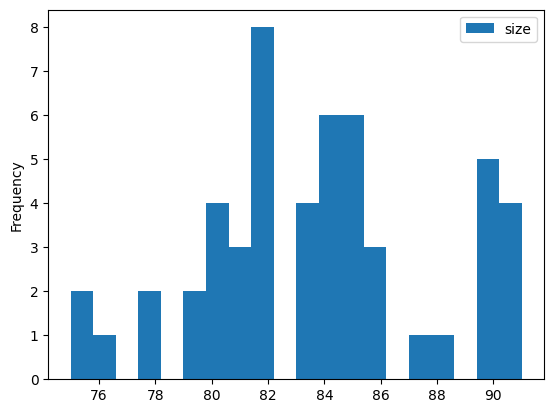

In [22]:
df[['size']].plot.hist(bins=20);

Para efeitos da presente análise considerou-se que `size` é normalmente distribuída. Devido à existência de alguns outliers na parte superior da amostra, usou-se o RobustScaler. A seguir, é feito o encoding.

In [23]:
def pre_proc(df):   
    """
    Pré-processamento do dataset obtido na API do Idealista:
    Encoding de 'floor' com MinMaxScaler, de 'size' com RobustScaler
    e de e 'hadLift' e 'hasPark' com OneHotEncoder  
    """
    
    # Encoding de 'floor' com MinMaxScaler
    minmax_scaler = MinMaxScaler()
    df[['floor', 'bathrooms']] = minmax_scaler.fit_transform(df[['floor', 'bathrooms']])

    # Encoding de 'size' com RobustScaler
    robust_scaler = RobustScaler()
    df[['size']] = robust_scaler.fit_transform(df[['size']])

    # Encoding de 'hadLift' e 'hasPark' com OneHotEncoder
    onehot_encodr = OneHotEncoder()

    lift_encoded = onehot_encodr.fit_transform(df[['hasLift']]).toarray()

    for index, column in enumerate(onehot_encodr.categories_[0]):
        df[column] = lift_encoded[:,index]

    park_encoded = onehot_encodr.fit_transform(df[['hasParking']]).toarray()

    for index, column in enumerate(onehot_encodr.categories_[0]):
        df[column] = park_encoded[:,index]
        
    df = df.drop(['hasLift', 'hasParking'], axis = 1)    
        
    return df

In [24]:
df = pre_proc(df)
df.head()

,floor,price,size,bathrooms,Lift,NoLift,NoPark,Park
0,0.166667,68000.0,-0.3,0.0,0.0,1.0,0.0,1.0
1,0.000000,116000.0,0.1,0.0,0.0,1.0,1.0,0.0
2,0.666667,116000.0,0.1,0.0,1.0,0.0,0.0,1.0
3,0.000000,120000.0,-0.1,0.0,1.0,0.0,0.0,1.0
4,0.500000,120000.0,-0.1,0.0,1.0,0.0,0.0,1.0


A ordem das colunas `Lift`, `NoLift`, `Park` e `NoPark` muda consoante o imóvel, visto que o OneHotEncoder altera a ordem dos nomes consoante o primeiro imóvel tem ou não garagem/elevador. Não é possível prever as posições das colunas, pelo que é preciso criar uma função para reordenar as colunas individualmente.

In [25]:
def ordenar_colunas(df):
    """
    Ordena as colunas do dataset para que estas tenham sempre a mesma sequência,
    devido à ordem variável que o OneHotEncoder dá. Também será usada no dataset
    criado posteriormente com os dados do utilizador.
    """
    
    df_ordenado = pd.DataFrame()
    df_ordenado['floor'] = df['floor']
    df_ordenado['size'] = df['size']
    df_ordenado['bathrooms'] = df['bathrooms']
    df_ordenado['Lift'] = df['Lift']
    df_ordenado['NoLift'] = df['NoLift']
    df_ordenado['Park'] = df['Park']
    df_ordenado['NoPark'] = df['NoPark']
    df_ordenado['price'] = df['price']
    
    return df_ordenado

In [26]:
df = ordenar_colunas(df)

O dataset está pronto para a modelação. Foi aplicada a Regressão Linear Multivariável.

In [27]:
lin_reg = LinearRegression()

X = df.drop('price', axis = 1)
y = df['price']

lin_reg.fit(X, y)

LinearRegression()

É criado um dataset com os dados introduzidos pelo utilizador.

In [28]:
user_info = [[
    user_andar,
    'TBD',
    user_area,
    user_wcs,
    user_tem_elev,
    user_tem_estac,
    ]]

user_df = pd.DataFrame(data=user_info, columns=df_columns) # São usados os nomes das colunas guardados anteriormente

É aplicado o pré-processamento aos dados do utilizador. O OneHotEncoder não desmultiplica as colunas quando detecta apenas uma categoria, pelo que essa separação é feita manualmente.

In [29]:
user_df = pre_proc(user_df)

if user_tem_elev == 1:
    user_df['Lift'] = 1.0
    user_df['NoLift'] = 0.0
else:
    user_df['Lift'] = 0.0
    user_df['NoLift'] = 1.0    
    
if user_tem_estac == 1:
    user_df['Park'] = 1.0
    user_df['NoPark'] = 0.0
else:
    user_df['Park'] = 0.0
    user_df['NoPark'] = 1.0    
    
user_df = ordenar_colunas(user_df)
X_user = user_df.drop(['price'], axis = 1)

E faz-se finalmente a previsão do valor obtido por Machine Learning.

In [30]:
y_user = lin_reg.predict(X_user)
print('O valor do apartamento obtido por Machine Learning é ' + str(round(int(y_user[0]),-2)) + ' €.')
print('(arredondado às centenas)')

O valor do apartamento obtido por Machine Learning é 183800 €.
(arredondado às centenas)
